Take PiCamera pictures and send blob positions down a UDP socket

In [1]:
import queue, socket, threading
port = 8299
s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
s.bind(("192.168.0.10", port))   # this is the Rpi itself
s.settimeout(10)


In [3]:
data, addr = s.recvfrom(1024)  # heartbeat


timeout: timed out

In [5]:
# This is the UDP socket setup in two threads that handles reconnections 
# and a heartbeat signal and hands the datastrings out through udpqueue
import queue, socket, threading

port = 8399

udpqueue = queue.Queue()  # data to be sent out on the socket
udpforgetconfirm = queue.Queue()

def udpincomingthread():
    while True:
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.bind(("192.168.0.10", port))   # this is the Rpi itself
        s.settimeout(10)   # timeout for heartbeat
        print("waiting on port:", port)
        try:
            for i in range(100000):
                data, addr = s.recvfrom(1024)  # heartbeat
                print("udpincoming", data, addr)
                if i == 0:
                    udpqueue.put_nowait(s) # hand the socket over with first connection
                    udpqueue.put_nowait(addr)
        except socket.timeout:
            pass
        udpqueue.put_nowait("FORGETSOCKET")
        udpforgetconfirm.get()   # hang here until we get the socket back.  
        s.close()

def udpqueuethread():
    s, addr = None, None
    while True:
        X = udpqueue.get()
        if isinstance(X, socket.socket):
            s, addr = X, udpqueue.get()
        elif X is "FORGETSOCKET":
            s, addr = None, None
            udpforgetconfirm.put_nowait("FSCONFIRMED")
        elif s is not None:
            s.sendto(X, addr)

threading.Thread(target=udpincomingthread, daemon=True).start()
threading.Thread(target=udpqueuethread, daemon=True).start()


waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399


In [25]:
import time
for i in range(100000):
    udpqueue.put_nowait(b"E%04d %04d" % (i%1000, 22))
    time.sleep(1/30)


waiting on port: 8299
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)


KeyboardInterrupt: 

waiting on port: 8299


In [6]:
# This sets up a thread acquire and save frames from the camera
import time, math, numpy, queue
import picamera, picamera.array
 
camera = picamera.PiCamera()
camera.resolution = (640, 480)
camera.framerate = 30
rawCapture = picamera.array.PiRGBArray(camera, size=camera.resolution)
 
# allow the camera to warmup
time.sleep(0.1)

qframes = queue.Queue(2)
qspareframes = queue.Queue()

nframes = 0
def capturecamerathread():
    global nframes
    gcam = camera.capture_continuous(rawCapture, format="rgb", use_video_port=True) # this is a generator!
    while True:
        rawCapture.truncate(0)
        tstamp = time.time()
        nframes += 1
        next(gcam)  # (the above defined generator actually is called here)
        if qspareframes.qsize() != 0:
            blankframe = qspareframes.get()
            if blankframe is None:
                break
            numpy.copyto(blankframe, rawCapture.array)
        else:
            blankframe = rawCapture.array.copy()
        qframes.put((tstamp, blankframe)) 
    print("leaving capturethread")
    
threading.Thread(target=capturecamerathread).start()

    

waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399


waiting on port: 8399


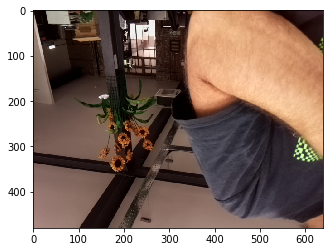

waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399


In [9]:
#tstamp, img = qframes.get()
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(img)

In [12]:
# This is the main loop
import cv2
workingmask = None
n = 0
while True:
    n += 1
    tstamp, img = qframes.get()
    cv2.GaussianBlur(img, (11, 11), 0, dst=img)
    cv2.cvtColor(img, cv2.COLOR_RGB2HSV, dst=img)
    h = 89
    if workingmask is None:
        workingmask = cv2.inRange(img, (h-5, 0, 0), (h+5,255,255))
    else:
        cv2.inRange(img, (h-5, 0, 0), (h+5,255,255), dst=workingmask)
    cv2.erode(workingmask, None, iterations=2, dst=workingmask)
    cnts, hierarchy = cv2.findContours(workingmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1:]
    if cnts:
        cnt = max(cnts, key=lambda X:cv2.contourArea(X))
    else:
        cnt = [ ]
    if len(cnt) >= 5 and cv2.contourArea(cnt)>100:
        ellipse = cv2.fitEllipse(cnt)
        ex, ey = int(ellipse[0][0]), int(ellipse[0][1])
    else:
        ex, ey = 999, n%1000
    udpqueue.put(b"E%.04d %0.4d" % (ex, ey))
    qspareframes.put(img)


waiting on port: 8399
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
waiting on port: 8399
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' 

udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hither

waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on port: 8399
waiting on

KeyboardInterrupt: 

In [21]:
cnt

array([[[350, 477]],

       [[349, 478]],

       [[348, 478]],

       [[347, 479]],

       [[344, 479]],

       [[352, 479]],

       [[351, 478]],

       [[351, 477]]], dtype=int32)

udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)
udpincoming b'hithere99' ('192.168.0.25', 49153)


In [6]:
from matplotlib import pyplot as plt
%matplotlib inline


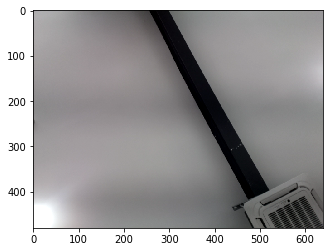

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)


In [9]:
plt.imshow(rawCapture.array)

In [4]:
gcam = camera.capture_continuous(rawCapture, format="rgb", use_video_port=True)
while True:
    rawCapture.truncate(0)
    next(gcam)  # framerate
    udpqueue.put_nowait(b"E%04d %04d" % (rawCapture.array[280,140,1], 23))

    

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hither

PiCameraValueError: Incorrect buffer length for resolution 640x480

udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)
udpincoming b'hithere99' ('192.168.0.25', 49157)


In [25]:
# we make a set of queues so we can do the camera capturing in a different thread
# which stalls on the individual frames
import queue
qframes = queue.Queue(maxsize=2)
qspareframes = queue.Queue(maxsize=0)
udpqueue = queue.Queue(maxsize=0)

workingmask = None


In [26]:
from threading import Thread

nframes = 0
def capturethread():
    global nframes
    gcam = camera.capture_continuous(rawCapture, format="rgb", use_video_port=True)
    while True:
        rawCapture.truncate(0)
        tstamp = time.time()
        nframes += 1
        next(gcam)  # framerate
        blankframe = (qspareframes.get() if qspareframes.qsize() != 0 else rawCapture.array.copy())
        if blankframe is None:
            break
        numpy.copyto(blankframe, rawCapture.array)
        qframes.put((tstamp, blankframe)) # blocked at size 2
    print("leaving thread")
Thread(target=capturethread).start()


1532391153.8046718 3


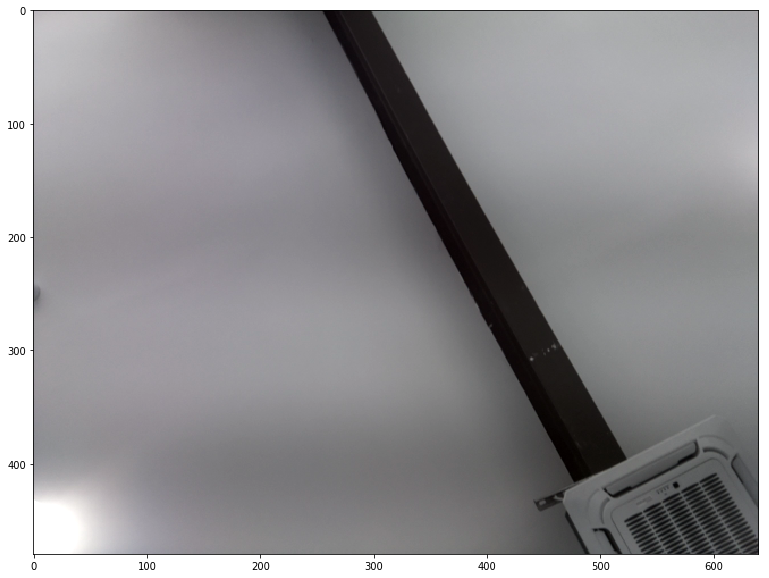

In [27]:
# just to see it
import imutils
tstamp, img = qframes.get()
print(tstamp, nframes)
plt.figure(figsize=(13,13))
plt.imshow(imutils.opencv2matplotlib(img))
qspareframes.put(img)


In [31]:
def skyblueellipses():
    global workingmask
    tstamp, img = qframes.get()
    cv2.GaussianBlur(img, (11, 11), 0, dst=img)  # 30ms
    cv2.cvtColor(img, cv2.COLOR_BGR2HSV, dst=img) # 8ms
    h = 89
    if workingmask is None:
        workingmask = cv2.inRange(img, (h-5, 0, 0), (h+5,255,255))  # make to the size
    cv2.inRange(img, (h-5, 0, 0), (h+5,255,255), dst=workingmask) # 8ms
    cv2.erode(workingmask, None, iterations=2, dst=workingmask)  # 12ms
    cnts, hierarchy = cv2.findContours(workingmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1:]  # 3ms
    ellipses = [ ]
    for cnt in cnts:
        if cv2.contourArea(cnt) > 100:
            ellipse = cv2.fitEllipse(cnt)  # 0.3ms
            ellipses.append(ellipse)

    r = ellipses[0][0][0] if ellipses else 0
    udpqueue.put(b"E%.04d %0.4d" % (int(r), 333))
    
    qspareframes.put(img)

skyblueellipses()
                         
                         

In [32]:
while True:
    skyblueellipses()

KeyboardInterrupt: 

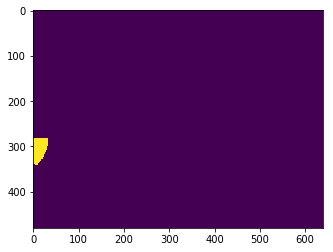

In [9]:
cv2.erode(workingmask, None, iterations=2, dst=workingmask)  # 12ms
plt.imshow(workingmask)

In [14]:
t0 = time.time()
for i in range(1000):
    skyblueellipses(i)
print((time.time()-t0)/1000)

0.1075643253326416


In [8]:
import queue
udpqueue = queue.Queue()
udpqueue.put_nowait

<bound method Queue.put_nowait of <queue.Queue object at 0x70e394b0>>

In [5]:
range()

TypeError: range expected 1 arguments, got 0

In [6]:
import Adafruit_SSD1306
from PIL import Image, ImageDraw, ImageFont
oleddisp = Adafruit_SSD1306.SSD1306_128_32(rst=24)
oleddisp.begin()
oleddisp.clear()
oleddisp.display()
oledimage = Image.new('1', (oleddisp.width, oleddisp.height))
oleddraw = ImageDraw.Draw(oledimage)

def oledellipses(ellipses, camerashape, n):
    oleddraw.rectangle((0, 0, oleddisp.width, oleddisp.height), outline=0, fill=0)
    xfac, yfac = oleddisp.width/camerashape[1], oleddisp.height/camerashape[0]
    #draw.text((10, 20), "hi", fill=1)
    
    for ellipse in ellipses:
        cx, cy = ellipse[0][0]*xfac, ellipse[0][1]*yfac
        rx, ry = max(1, ellipse[1][0]*xfac/2), max(1, ellipse[1][1]*yfac/2)
        oleddraw.ellipse((int(cx-rx), int(cy-ry), int(cx+rx), int(cy+ry)), fill=1, outline=1)
    oleddraw.text((0,0), str(n), fill=1)
    oleddisp.image(oledimage)
    oleddisp.display()
